In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import os
from ast import literal_eval  # 문자열로 저장된 딕셔너리를 진짜 딕셔너리로 변환
import numpy as np
import multiprocessing as mp # session_start / session_end 매칭 시 병렬처리

# GCS 파일 경로에서 데이터 불러오기 위한 라이브러리
from google.cloud import storage
from google.oauth2 import service_account

In [2]:

# 기본 정보 확인 함수 
def show_df_info(df, df_name):
    """
    DataFrame의 기본 정보와 통계 요약을 출력하는 함수
    """
    print(f"\n{df_name} 형태:")
    display(df.shape)
    print(f"\n{df_name} 첫 5행:")
    display(df.head())
    print(f"\n{df_name} 정보:")
    df.info()
    print(f"\n{df_name} 통계 요약:")
    display(df.describe())
    print(f"\n{df_name} 통계 요약:")
    display(df.describe(include = 'O'))
    print(f"\n{df_name} 결측치 확인:")
    display(df.isnull().sum())
    # print(f"\n{df_name} 중복값 확인:")
    # print(df.iloc[:,1:].duplicated().sum())

# 파일 불러오기 및 확인

In [38]:
# # 230430 test
# # GCS 파일 경로
# gcs_path = "gs://part4_project/events/230430.parquet"
# # 데이터 불러오기
# test_df = pd.read_parquet(gcs_path, storage_options={"token": None}) # key_path // 오늘은 에러나서 None으로...

# # 확인
# display(test_df.head())
# test_df.shape

In [39]:
# 인증
key_path = "../config/codeit_project_vm_key.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCS 클라이언트 생성
client = storage.Client(credentials=credentials)
bucket = client.bucket("part4_project")

# 'events_ver2/' 경로에 있는 .parquet 파일 리스트 가져오기
blobs = bucket.list_blobs(prefix="events_ver2/")
events_file_list = [f"gs://part4_project/{blob.name}" for blob in blobs if blob.name.endswith(".parquet")] 

# 결과 확인
events_file_list

['gs://part4_project/events_ver2/230430.parquet',
 'gs://part4_project/events_ver2/230506.parquet',
 'gs://part4_project/events_ver2/230512.parquet',
 'gs://part4_project/events_ver2/230518.parquet',
 'gs://part4_project/events_ver2/230524.parquet',
 'gs://part4_project/events_ver2/230530.parquet',
 'gs://part4_project/events_ver2/230605.parquet',
 'gs://part4_project/events_ver2/230611.parquet',
 'gs://part4_project/events_ver2/230617.parquet',
 'gs://part4_project/events_ver2/230623.parquet',
 'gs://part4_project/events_ver2/230629.parquet',
 'gs://part4_project/events_ver2/230705.parquet',
 'gs://part4_project/events_ver2/merged_df_final.parquet']

In [40]:
# 파일들을 각각 변수로 불러오기
for title in events_file_list:
    # GCS 경로에서 파일명 추출
    file_name = title.split('/')[-1].replace('.parquet', '')
    
    # Parquet 파일 읽기
    df = pd.read_parquet(title, storage_options={"token": key_path})
    
    # 각각의 이름_df로 저장 (ex. device_properties_df)
    globals()[f"df_{file_name}"] = df
    
    # 출력 확인 (shape + head)
    print(f"\n df_{file_name} 불러오기 완료")
    print(f"→ shape: {df.shape}")
    print(f"→ 첫 5행:")
    display(df.head())
    
    # event_datetime이 있는 경우 날짜 변환 및 범위 출력
    if 'event_datetime' in df.columns:
        try:
            df['event_datetime'] = pd.to_datetime(df['event_datetime'])
            min_date = df['event_datetime'].min().date()
            max_date = df['event_datetime'].max().date()
            print(f"📆 df_{file_name} 의 event_datetime 범위: {min_date} ~ {max_date}")
        except Exception as e:
            print(f"⚠️ df_{file_name} 의 event_datetime 변환 중 오류 발생: {e}")
    else:
        print(f"⛔ df_{file_name} 에는 'event_datetime' 컬럼이 존재하지 않음")


 df_230430 불러오기 완료
→ shape: (8588422, 8)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,description,location,devicemodel,language
0,2023-05-01 09:00:00,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,cfc34eab-6930-488b-8109-70d37cec7dae,button,다음,signotherinputscreen,"iPhone10,4",ko-KR
1,2023-05-01 09:00:00,n3PI8GZnRFOKpJslIRgckMeRiln1,0dde2ecb-ff03-440f-98f3-94f20978b796,button,vote 선택,homevotesscreen,"iPhone14,4",ko-CA
2,2023-05-01 09:00:00,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,b50774ed-24ce-49e1-9383-945ff3aea9ff,button,친구선택,homeenquetescreen,SM-A125N,ko
3,2023-05-01 09:00:00,QjToElcYNkVxszJDHBhqtITlzDJ3,0999c6b6-c579-4c0f-916c-9a113010f84a,button,이름 셔플!,homeenquetescreen,SM-A305N,ko
4,2023-05-01 09:00:00,VRpXf303RGU730fIO4EjWstzAJi1,45985493-ed35-4cc5-935f-1bcf922e213c,button,앱바 뒤로가기,homefriendprofilescreen,"iPhone14,5",ko-KR


📆 df_230430 의 event_datetime 범위: 2023-05-01 ~ 2023-05-07

 df_230506 불러오기 완료
→ shape: (7106588, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-07 09:00:00,OoWMTpTWpUa4m8I1RiKOk75Xnvs1,498dbc0f-4537-41dc-93ec-f4406302a3b0,$session_end,"iPhone14,5",ko-KR
1,2023-05-07 09:00:00,CrFi87nvwiVvHExxP9uSfIHOmBy1,7770afa8-e228-4736-aa2a-658ebe2e3d25,$session_end,"iPhone12,8",ko-KR
2,2023-05-07 09:00:00,W6frWgWJtbWTJwdm6eVWPGKwY2Y2,9fbdc45d-a74a-4d9f-9d40-0f400b72877e,$session_end,"iPhone14,8",ko-KR
3,2023-05-07 09:00:00,4EFB4D45-0AAF-424A-8E4E-2F19249C8892,4efb4d45-0aaf-424a-8e4e-2f19249c8892,$session_start,"iPhone12,3",ko-KR
4,2023-05-07 09:00:00,JdxVFvtz6AcxxOZVvl6plHayjYJ3,96348488-4d6a-49a8-8995-452718157fd7,$session_start,SM-A315N,ko


📆 df_230506 의 event_datetime 범위: 2023-05-07 ~ 2023-05-13

 df_230512 불러오기 완료
→ shape: (12188804, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-13 09:00:00,6zkImM4PD0MHIbJ9zRVXs6vX6e62,cb7a48f6-6882-4223-98fd-4fe73cb3903b,$session_start,"iPhone14,4",ko-KR
1,2023-05-13 09:00:00,Sq5vui6fg2Nhz2EHeC8e4PWyxo13,b2512274-1161-4fd2-a4e8-b40f1ecc0372,$session_end,"iPhone12,8",ko-KR
2,2023-05-13 09:00:00,RyWeiMNMACUhbawb63ITBMX1c1U2,75f9bcd9-78c8-4dd6-a91e-0faf85a10526,$session_end,"iPhone15,2",ko-KR
3,2023-05-13 09:00:00,3OaNLuqTVDTkMEc8IsZNBxF9hsH2,380ebcac-4f9d-4004-968d-cf6372908adc,$session_start,"iPhone12,1",en-KR
4,2023-05-13 09:00:00,rWBKAsEaG3cpHuAPRyohFr3k6PB2,290b1a00-659d-4d24-a26d-5524d7ac44ce,$session_end,"iPhone14,3",ko-KR


📆 df_230512 의 event_datetime 범위: 2023-05-13 ~ 2023-05-19

 df_230518 불러오기 완료
→ shape: (8224556, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-19 09:00:00,nALWgF7izudSzKXArsiAOaYYsr23,c370e36d-b84c-4c97-af37-db356caf1741,$session_start,"iPhone14,2",ko-KR
1,2023-05-19 09:00:00,E9A0131C-A70A-4917-88D8-257223F0A767,e9a0131c-a70a-4917-88d8-257223f0a767,$session_end,"iPhone11,2",ko-KR
2,2023-05-19 09:00:00,euhK4oLwdGPVT6sPNNN1Rs7xEKz1,2ab9b1b1-41a7-4f6e-af31-85daac4509ea,$session_start,"iPhone14,7",ko-KR
3,2023-05-19 09:00:00,TYAFQPAWozbqfQ3I296QuXJnWrx1,c3236b64-a328-4743-8afd-461f85f1f1e0,$session_start,"iPhone15,3",ko-KR
4,2023-05-19 09:00:00,XhhuxAQvEcXdlD1JjbPC8H3AF602,efe3418d-ad59-4a20-a5f9-43d2195d1a08,$session_start,"iPhone14,7",ko-KR


📆 df_230518 의 event_datetime 범위: 2023-05-19 ~ 2023-05-25

 df_230524 불러오기 완료
→ shape: (2586328, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-25 09:00:00,TeeVVRGrpuXE5q6f7pAu9ULVNvG3,b6afceaa-cc9c-4a66-b92f-9e202f9eb328,$session_start,"iPhone14,7",ko-KR
1,2023-05-25 09:00:00,9tcpOeHvyldCUXMgRyFVQI86rf13,54a8af4d-47bf-4951-87c2-1817b26d1c31,$session_start,"iPhone12,1",ko-KR
2,2023-05-25 09:00:00,aiDrtN8uHiQXRXmLMJhf27hKA4B3,b08ee1df-0bc6-4b38-9474-8cbc55fd6f17,$session_start,"iPhone12,1",ko-KR
3,2023-05-25 09:00:00,Oqmt3cCrCQZAa0TT3B4s2kTOG1k1,ace73d0e-04d6-4d03-9460-a0a1143253f7,$session_start,"iPhone11,8",ko-KR
4,2023-05-25 09:00:00,GA1Nz2ehK2TmsRcqBzXQn6hkDHH2,2adda5ce-1d37-43cd-8cbd-c75c06f84f74,$session_start,"iPhone14,7",ko-KR


📆 df_230524 의 event_datetime 범위: 2023-05-25 ~ 2023-05-31

 df_230530 불러오기 완료
→ shape: (2313, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-31 09:01:06,VAb6ai91iKPZZQhGKenhHZpAG5B2,6DA6A8DC-1E61-4643-963A-ED3D782BE77A,$session_start,"iPhone15,2",ko-KR
1,2023-05-31 09:02:20,fe556647-de19-43ff-9152-b3c38a8b4d26,fe556647-de19-43ff-9152-b3c38a8b4d26,$session_start,SM-G991N,ko
2,2023-05-31 09:02:46,LsAqqCTVtQPpevfSHXI8oRepVs73,5D47D549-EF22-41F3-A0D2-AD9EC1D21A2B,$session_start,"iPhone15,2",ko-KR
3,2023-05-31 09:03:50,NBfi1jm5FKfB6We7YfVRHFgeJY83,FD419DE8-B3CE-4630-B234-959ADA5F47CF,$session_start,"iPhone9,3",ko-KR
4,2023-05-31 09:04:12,3CBFC179-1BB1-40A2-84EF-C39EFBD40C14,3CBFC179-1BB1-40A2-84EF-C39EFBD40C14,$session_start,"iPhone14,7",ko-KR


📆 df_230530 의 event_datetime 범위: 2023-05-31 ~ 2023-06-06

 df_230605 불러오기 완료
→ shape: (649, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-06 09:01:35,7918DF48-A239-45CE-AC1E-7E2E356454C4,$session_start,"iPhone13,1",ko-KR
1,2023-06-06 09:16:11,02F51978-FDD9-4C66-AE8D-820943E00AEF,$session_start,"iPad13,8",ko-KR
2,2023-06-06 09:27:07,E75FFCB7-5AAB-4674-AE34-7A231136C367,$session_start,"iPad13,4",ko-KR
3,2023-06-06 09:28:38,92D752F2-E7B9-4C01-892B-C9B3F1416B74,$session_start,"iPhone15,2",ko-KR
4,2023-06-06 09:44:06,47955d3d-b77f-47a6-9d3e-3fcb45a350df,$session_start,SM-A235N,ko


📆 df_230605 의 event_datetime 범위: 2023-06-06 ~ 2023-06-12

 df_230611 불러오기 완료
→ shape: (263, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-12 09:00:33,8A5F41F9-D126-453C-8EA8-E0C2484584E3,$session_start,"iPhone13,1",ko-KR
1,2023-06-12 09:10:18,A81A2A45-6260-41C6-B81B-071F006D60BD,$session_start,"iPhone14,2",ko-KR
2,2023-06-12 09:17:21,CD41A81E-8D5C-4E7A-8289-587AD8C306F5,$session_start,"iPhone13,1",ko-KR
3,2023-06-12 09:21:00,5A92997F-362C-400B-8613-893A2FD6197F,$session_start,"iPhone13,2",ko-KR
4,2023-06-12 09:22:44,7FB46B64-B405-49C4-9378-8FABA73D4038,$session_start,"iPad13,16",ko-KR


📆 df_230611 의 event_datetime 범위: 2023-06-12 ~ 2023-06-18

 df_230617 불러오기 완료
→ shape: (4120154, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-18 09:07:08,8b6f9e35-473d-45d7-b8ad-884359609fdd,$session_start,"iPhone15,2",ko-KR
1,2023-06-18 09:07:11,8b6f9e35-473d-45d7-b8ad-884359609fdd,$session_end,"iPhone15,2",ko-KR
2,2023-06-18 09:07:34,4ff18855-0de6-4e51-a00c-7cdfe36bfc64,$session_start,"iPhone8,4",ko-KR
3,2023-06-18 10:01:12,99a6de2d-d222-46ff-81c2-729daff8e688,$session_start,"iPad13,1",ko-KR
4,2023-06-18 11:30:47,4ff18855-0de6-4e51-a00c-7cdfe36bfc64,$session_start,"iPhone8,4",ko-KR


📆 df_230617 의 event_datetime 범위: 2023-06-18 ~ 2023-06-24

 df_230623 불러오기 완료
→ shape: (6820315, 4)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key
0,2023-06-24 09:00:00,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,view_question_question
1,2023-06-24 09:00:00,XjKd6fh3CCfKJxobCxGssTIcoCp1,216d665c-7e79-414d-b9e4-100a9a1d4737,view_timeline_tap
2,2023-06-24 09:00:00,QepNLzWEkTNvfHSSkhCldJH5eMw2,b3de9810-5a82-4192-a69d-a2535307a88f,view_message_tap
3,2023-06-24 09:00:00,C03B343F-B566-46BA-9030-8E441B71EC33,c03b343f-b566-46ba-9030-8e441b71ec33,$session_start
4,2023-06-24 09:00:00,C03B343F-B566-46BA-9030-8E441B71EC33,c03b343f-b566-46ba-9030-8e441b71ec33,view_home_tap


📆 df_230623 의 event_datetime 범위: 2023-06-24 ~ 2023-06-30

 df_230629 불러오기 완료
→ shape: (3839972, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-30 09:00:00,6a9bbd4a-7427-401c-80b3-6d82161ccb3b,$session_end,SM-A536N,ko
1,2023-06-30 09:00:00,dfea6e11-6022-4bfa-800b-61b87dff0ac1,view_timeline_tap,SM-N971N,ko
2,2023-06-30 09:00:00,ebb00523-9d18-445c-97ee-239dd8a68e59,click_question_open,"iPhone13,1",ko-KR
3,2023-06-30 09:00:00,9652674b-57ea-4d32-8f9c-21c11308aaef,view_home_tap,SM-M536S,ko
4,2023-06-30 09:00:00,40b75183-c3f4-4173-ab6f-9bc64cbc70de,view_questions_tap,"iPhone14,4",ko-KR


KeyboardInterrupt: 

In [ ]:
# 20230430의 event_datetime, session_id, device_id,	event_key, devicemodel,	language 컬럼만 가져오면 5월꺼랑 concat 가능
# 20230506 ~ 20230530 파일까지 concat 가능
# 20230605 ~ 20230617 파일까지 concat 가능

# 전체 파일 concat 하기

In [ ]:
columns = ['event_datetime', 'device_id', 'event_key']

merged_df = pd.concat([
    df_230430[columns],
    df_230506[columns],
    df_230512[columns],
    df_230518[columns],
    df_230524[columns],
    df_230530[columns],
    df_230605[columns],
    df_230611[columns],
    df_230617[columns],
    df_230623[columns],
    df_230629[columns],
    df_230705[columns],
])

merged_df.shape

(56357032, 3)

In [ ]:
merged_df.duplicated().sum()

586903

In [ ]:
# 중복값 제거 후 저장
merged_df = merged_df.drop_duplicates()
merged_df.shape

(55770129, 3)

In [ ]:
# parquet으로 내보내기 
merged_df.to_parquet("../data/merged_df.parquet", engine="pyarrow", compression="snappy")

In [ ]:
# merged_df 불러오기 테스트
merged_df_test = pd.read_parquet("/home/codeit_project_vm/codeit_project/codeit-project-docker/data/merged_df.parquet")

print(merged_df_test.shape)
merged_df_test.head()

(55770129, 3)


,event_datetime,device_id,event_key
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button


# 23.04.30 + 23.05.06 ~ 23.05.30. 파일 병합 (23-05-01 ~ 23-06-06 기간) EDA

In [ ]:
# 20230430 파일의 event_datetime, session_id, device_id, event_key, devicemodel, language 컬럼만 가져와서 저장
df_230430_new = df_230430[['event_datetime', 'session_id', 'device_id', 'event_key', 'devicemodel', 'language']]

In [ ]:
# 20230506 ~ 20230530 파일까지 concat

# 합치고 싶은 파일명 리스트
df_names = ['df_230506', 'df_230512', 'df_230518', 'df_230524', 'df_230530']

# globals()에서 해당 이름의 변수 가져와 리스트에 담기
dfs_to_concat = [globals()[name] for name in df_names]

# concat 병합
merged_0506_0530_df = pd.concat(dfs_to_concat, ignore_index=True)

# 결과 확인
print(f"병합된 DataFrame shape: {merged_0506_0530_df.shape}")
merged_0506_0530_df.head()

병합된 DataFrame shape: (30108589, 6)


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-07 09:00:00,OoWMTpTWpUa4m8I1RiKOk75Xnvs1,498dbc0f-4537-41dc-93ec-f4406302a3b0,$session_end,"iPhone14,5",ko-KR
1,2023-05-07 09:00:00,CrFi87nvwiVvHExxP9uSfIHOmBy1,7770afa8-e228-4736-aa2a-658ebe2e3d25,$session_end,"iPhone12,8",ko-KR
2,2023-05-07 09:00:00,W6frWgWJtbWTJwdm6eVWPGKwY2Y2,9fbdc45d-a74a-4d9f-9d40-0f400b72877e,$session_end,"iPhone14,8",ko-KR
3,2023-05-07 09:00:00,4EFB4D45-0AAF-424A-8E4E-2F19249C8892,4efb4d45-0aaf-424a-8e4e-2f19249c8892,$session_start,"iPhone12,3",ko-KR
4,2023-05-07 09:00:00,JdxVFvtz6AcxxOZVvl6plHayjYJ3,96348488-4d6a-49a8-8995-452718157fd7,$session_start,SM-A315N,ko


In [ ]:
# 20230430과 5월 파일들 concat
merged_0430_0530_df = pd.concat([df_230430_new, merged_0506_0530_df], ignore_index=True)
merged_0430_0530_df.shape

(38697011, 6)

In [ ]:
show_df_info(merged_0430_0530_df, "merged_0430_0530_df")


merged_0430_0530_df 형태:


(38697011, 6)


merged_0430_0530_df 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-01 09:00:00,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,cfc34eab-6930-488b-8109-70d37cec7dae,button,"iPhone10,4",ko-KR
1,2023-05-01 09:00:00,n3PI8GZnRFOKpJslIRgckMeRiln1,0dde2ecb-ff03-440f-98f3-94f20978b796,button,"iPhone14,4",ko-CA
2,2023-05-01 09:00:00,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,b50774ed-24ce-49e1-9383-945ff3aea9ff,button,SM-A125N,ko
3,2023-05-01 09:00:00,QjToElcYNkVxszJDHBhqtITlzDJ3,0999c6b6-c579-4c0f-916c-9a113010f84a,button,SM-A305N,ko
4,2023-05-01 09:00:00,VRpXf303RGU730fIO4EjWstzAJi1,45985493-ed35-4cc5-935f-1bcf922e213c,button,"iPhone14,5",ko-KR



merged_0430_0530_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38697011 entries, 0 to 38697010
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   session_id      object        
 2   device_id       object        
 3   event_key       object        
 4   devicemodel     object        
 5   language        object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.7+ GB

merged_0430_0530_df 통계 요약:


,event_datetime
count,38697011
mean,2023-05-14 08:22:58.322573056
min,2023-05-01 09:00:00
25%,2023-05-08 21:59:00
50%,2023-05-15 06:10:45
75%,2023-05-20 03:40:53
max,2023-06-06 08:55:03



merged_0430_0530_df 통계 요약:


,session_id,device_id,event_key,devicemodel,language
count,38697011,38697011,38697011,38697011,38697011
unique,1516384,902150,3,823,267
top,2hVUipDkRTgPgjcWKfg1ZX7BiCF2,ae7bb627-df86-426b-b731-8066ed4d9888,$session_start,"iPhone14,5",ko-KR
freq,3395,3411,18642487,4887633,29427691



merged_0430_0530_df 결측치 확인:


event_datetime    0
session_id        0
device_id         0
event_key         0
devicemodel       0
language          0
dtype: int64

- 2023-05-01 09:00:00 ~ 2023-06-06 08:55:03까지 있음(0430 ~ 0530 병합 시)
- session_id의 고유값 개수가 device_id 보다 많음
- event_key : session_start, session_end, button 3개인데, session_start가 가장 많음

In [ ]:
# event_key 고유값 개수 확인 
merged_0430_0530_df['event_key'].value_counts()  # button은 230430 파일만 있음 

event_key
$session_start    18642487
$session_end      12602588
button             7451936
Name: count, dtype: int64

- session_start가 session_end보다 많음 -> 모든게 짝지어지진 않을 확률 높음....
- button은 0430 파일에만 있는거라 사실 의미 없음.

In [ ]:
# 무엇을 기준으로 봐야함??
# session_id 별로 device_id 몇 개인지
merged_0430_0530_df.groupby('session_id')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)

,session_id,device_id
936863,ISz4K45Bu6RApABHjdl0DAh1Hn33,138
1458901,uk4VelhHFdeWCeeM3RssqIOQSpD3,90
1047963,Sbxhd2ychEQTpCPiADRAYAeASbJ2,78
54231,0bTXuQ12OKdW9PZDIoz3lzICpqR2,77
1477733,wS6OVpRZvGfmyD56GJJDIRH0KC92,73
...,...,...
511179,81BE9E73-AFB5-49A7-B99F-CB32FBA7C9F2,1
511178,81BE9B50-2F49-4E1B-908E-E3F04C05075C,1
511177,81BE8055-CD0E-41CE-8695-EB8C978E3B39,1
511176,81BE6E16-A774-487C-B965-B77974729279,1


In [ ]:
# 샘플 session_id 확인
merged_0430_0530_df[merged_0430_0530_df['session_id'] == 'ISz4K45Bu6RApABHjdl0DAh1Hn33'].head(20)

,event_datetime,session_id,device_id,event_key,devicemodel,language
27633371,2023-05-19 07:13:08,ISz4K45Bu6RApABHjdl0DAh1Hn33,7084bff6-d6c0-45d5-a8ae-0c1eb096d909,$session_start,"iPhone15,2",ko-KR
27973814,2023-05-19 09:48:06,ISz4K45Bu6RApABHjdl0DAh1Hn33,5c1cbebe-573c-4586-b56b-14303edcb200,$session_start,"iPhone15,2",ko-KR
28041032,2023-05-19 11:04:21,ISz4K45Bu6RApABHjdl0DAh1Hn33,cb0ea82b-5bde-41ca-a24b-fe6c1e9dd140,$session_start,"iPhone15,2",ko-KR
28055286,2023-05-19 12:06:42,ISz4K45Bu6RApABHjdl0DAh1Hn33,f50e1bf4-15af-4b60-973a-56dc02abf55d,$session_start,"iPhone15,2",ko-KR
28217796,2023-05-19 16:54:18,ISz4K45Bu6RApABHjdl0DAh1Hn33,49cff50a-3bdc-46b0-918f-1e55031cb9eb,$session_start,"iPhone15,2",ko-KR
28376040,2023-05-19 18:39:44,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_start,"iPhone15,2",ko-KR
28376375,2023-05-19 18:40:12,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_end,"iPhone15,2",ko-KR
28463104,2023-05-19 20:39:40,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_start,"iPhone15,2",ko-KR
28464693,2023-05-19 20:41:26,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_end,"iPhone15,2",ko-KR
28494497,2023-05-19 21:19:20,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_start,"iPhone15,2",ko-KR


In [ ]:
# device_id 별로 session_id 몇 개인지
merged_0430_0530_df.groupby('device_id')['session_id'].nunique().reset_index().sort_values(by='session_id', ascending=False)

,device_id,session_id
611246,ad97ef42-477f-42c0-b1fd-3ec83098020a,9
787075,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,7
90091,19a3d22c-5b44-49b6-93a5-d124d5245b4f,7
450335,7fd7f977-8a83-49e4-a9e1-127a7ade4e84,6
599582,aa3da82a-ba4b-4134-8dcb-5494357fd6aa,6
...,...,...
521707,944d7ad2-13ec-4cab-990c-6038b4f3e39c,1
314154,5933b47d-a276-4750-b245-d18e0a979f8d,1
138923,278a4bd6-1704-472c-949b-609155d6499a,1
734151,d0689d28-6352-4d6a-81bd-d3bf82d67c98,1


In [ ]:
(merged_0430_0530_df.groupby('device_id')['session_id'].nunique().reset_index().sort_values(by='session_id', ascending=False)['session_id'] == 1).sum()

160562

- device_id 902150개 중에서 160562개는 session_id 1개
- 741588개는 2개 이상의 session_id를 가지고 있음

In [ ]:
# 샘플 device_id 확인
merged_0430_0530_df[merged_0430_0530_df['device_id'] == 'ad97ef42-477f-42c0-b1fd-3ec83098020a']

,event_datetime,session_id,device_id,event_key,devicemodel,language
270510,2023-05-01 10:17:52,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270705,2023-05-01 10:17:58,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270763,2023-05-01 10:17:59,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270847,2023-05-01 10:18:01,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270935,2023-05-01 10:18:03,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
...,...,...,...,...,...,...
6152885,2023-05-03 07:47:17,TNJwJdeyQafnkFcLuUN8kUjWRJH3,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
9405190,2023-05-08 10:21:01,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
9405200,2023-05-08 10:21:02,fvscVUlvnnTqnH8FopkHiTIu3jg1,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
9406756,2023-05-08 10:24:05,fvscVUlvnnTqnH8FopkHiTIu3jg1,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR


In [ ]:
# event_key 가 button인 경우 제외하고 확인
merged_0430_0530_df[(merged_0430_0530_df['device_id'] == 'ad97ef42-477f-42c0-b1fd-3ec83098020a') & \
                     (merged_0430_0530_df['event_key'] != 'button')]

,event_datetime,session_id,device_id,event_key,devicemodel,language
271364,2023-05-01 10:18:15,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
271412,2023-05-01 10:18:16,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
273083,2023-05-01 10:18:56,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
273106,2023-05-01 10:18:57,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
273525,2023-05-01 10:19:08,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
273574,2023-05-01 10:19:10,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
274000,2023-05-01 10:19:21,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
274055,2023-05-01 10:19:22,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
275086,2023-05-01 10:19:49,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
275148,2023-05-01 10:19:51,YBj6GbybYJU17f2Z4YMAexV7ys72,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR


- session_id가 같을 때 session_start와 session_end가 잘 짝지어져서 나옴
- 어떤 session_id는 device_id와 같은데 알파벳만 소문자 -> 대문자로 바뀜 (AD97EF42-477F-42C0-B1FD-3EC83098020A)

In [ ]:
# devide_id 기준 하나 더 확인
# event_key 가 button인 경우 제외하고 확인
merged_0430_0530_df[(merged_0430_0530_df['device_id'] == 'df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6') & \
                     (merged_0430_0530_df['event_key'] != 'button')].head(20)

,event_datetime,session_id,device_id,event_key,devicemodel,language
14434702,2023-05-12 16:32:46,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
14436759,2023-05-12 16:34:07,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
14436785,2023-05-12 16:34:09,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
17013466,2023-05-14 04:59:47,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
17083578,2023-05-14 05:35:44,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
17314061,2023-05-14 07:22:09,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
17805736,2023-05-14 16:52:56,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
17990904,2023-05-14 19:50:13,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
18006411,2023-05-14 19:58:39,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
18006412,2023-05-14 19:58:39,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko


- 이전에 확인한 device_id와 비슷한 양상을 보임
- session_id == device_id 인 경우가 있음 

In [ ]:
# session_id와 device_id 같은 경우 확인
merged_0430_0530_df[merged_0430_0530_df['session_id'] == merged_0430_0530_df['device_id']]['session_id'].nunique()

270844

- session_id 고유값 개수 : 1516384
- device_id 고유값 개수 : 902150   
그 중, 270844개가 동일함!! (대문자 <-> 소문자 까지 매칭한다면 더 많아질지도?)

In [ ]:
# 대소문자를 무시하고 비교 (모두 소문자로 변환한 후 비교)
merged_0430_0530_df[merged_0430_0530_df['session_id'].str.lower() == merged_0430_0530_df['device_id'].str.lower()]['session_id'].str.lower().nunique()

835512

- 대소문자까지 변환해서 모두 같은 경우 835512개! 

In [ ]:
835512 / 902150 * 100 # device_id의 약 92.6%가 session_id와 동일하거나 유사함(대소문자 차이)

92.61342348833342

# 지표 도출_요일/시간대별 사용량

In [ ]:
# 데이터 불러오기 (merged_df)
# 경로 설정
file_path = "gs://part4_project/events_ver2/merged_df_final.parquet"
key_path = "../config/codeit_project_vm_key.json"

# GCS에서 parquet 불러오기
merged_df_final = pd.read_parquet(file_path, storage_options={"token": key_path})

# 확인
print(merged_df_final.shape)
print(merged_df_final.info())

(55770129, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB
None


In [ ]:
show_df_info(merged_df_final, "merged_df_final")


merged_df_final 형태:


(55770129, 3)


merged_df_final 첫 5행:


,event_datetime,device_id,event_key
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button



merged_df_final 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB

merged_df_final 통계 요약:


,event_datetime
count,55770129
mean,2023-05-28 23:36:05.667766784
min,2023-05-01 09:00:00
25%,2023-05-12 16:25:14
50%,2023-05-19 18:48:13
75%,2023-06-24 04:50:36
max,2023-07-12 08:59:59



merged_df_final 통계 요약:


,device_id,event_key
count,55770129,55770129
unique,952830,46
top,14f09012-3294-4c51-ad67-e8e09604004f,$session_start
freq,8938,20513061



merged_df_final 결측치 확인:


event_datetime    0
device_id         0
event_key         0
dtype: int64

In [ ]:
# event_datetime에서 년, 월, 일, 시간대, 요일 추출 컬럼 생성
merged_df_final['event_hour'] = merged_df_final['event_datetime'].dt.hour
merged_df_final['event_day_of_week'] = merged_df_final['event_datetime'].dt.day_of_week
merged_df_final['event_day_name'] = merged_df_final['event_datetime'].dt.day_name()

merged_df_final.head()

,event_datetime,device_id,event_key,event_hour,event_day_of_week,event_day_name
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button,9,0,Monday
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button,9,0,Monday
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button,9,0,Monday
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button,9,0,Monday
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button,9,0,Monday


,event_day_of_week,event_day_name,session_start_count
0,0,Monday,2676857
1,1,Tuesday,2623982
2,2,Wednesday,2996800
3,3,Thursday,2872643
4,4,Friday,2976068
5,5,Saturday,3169337
6,6,Sunday,3197374


count    7.000000e+00
mean     2.930437e+06
std      2.222508e+05
min      2.623982e+06
25%      2.774750e+06
50%      2.976068e+06
75%      3.083068e+06
max      3.197374e+06
Name: session_start_count, dtype: float64

/tmp/ipykernel_71066/686626548.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', palette='viridis')


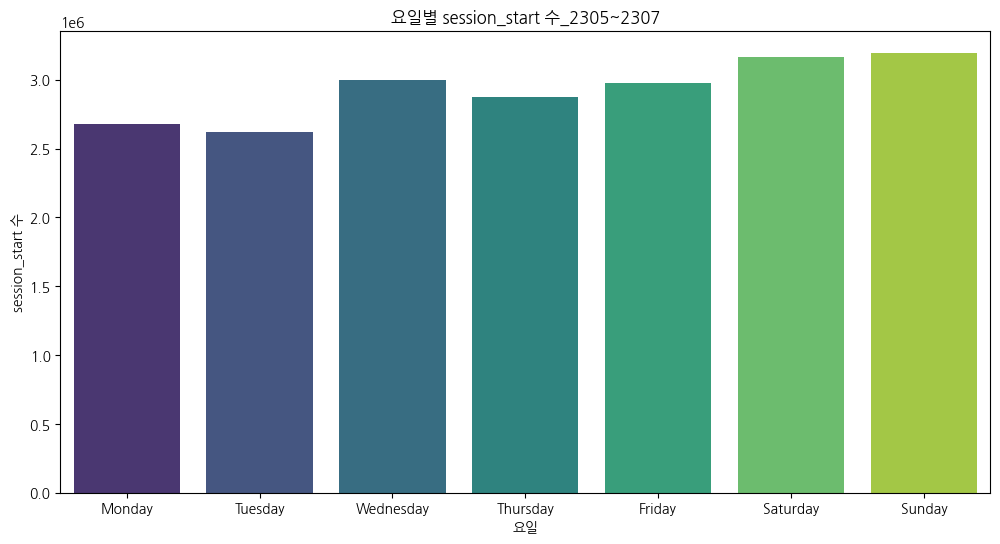

In [ ]:
# session_id별로 event_key가 session_start인 경우의 요일, 시간대 알아내기
session_start_df = merged_df_final[merged_df_final['event_key'] == '$session_start'].copy()

# 요일별로 session_start 수 집계
session_start_week_counts = session_start_df.groupby(['event_day_of_week', 'event_day_name']).size().reset_index(name='session_start_count')
display(session_start_week_counts)
display(session_start_week_counts['session_start_count'].describe())

# 요일별로 session_start 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', palette='viridis')
plt.title('요일별 session_start 수_2305~2307')
plt.xlabel('요일')
plt.ylabel('session_start 수')   
plt.xticks(ticks = range(7), labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()  

,event_hour,count
0,0,1003471
1,1,1266353
2,2,1246948
3,3,1279374
4,4,1313781
5,5,1387890
6,6,1517621
7,7,1642400
8,8,1434009
9,9,1026499


count    2.400000e+01
mean     8.547109e+05
std      4.808628e+05
min      5.516100e+04
25%      5.325498e+05
50%      8.688175e+05
75%      1.269608e+06
max      1.642400e+06
Name: count, dtype: float64

/tmp/ipykernel_71066/129983259.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='viridis')


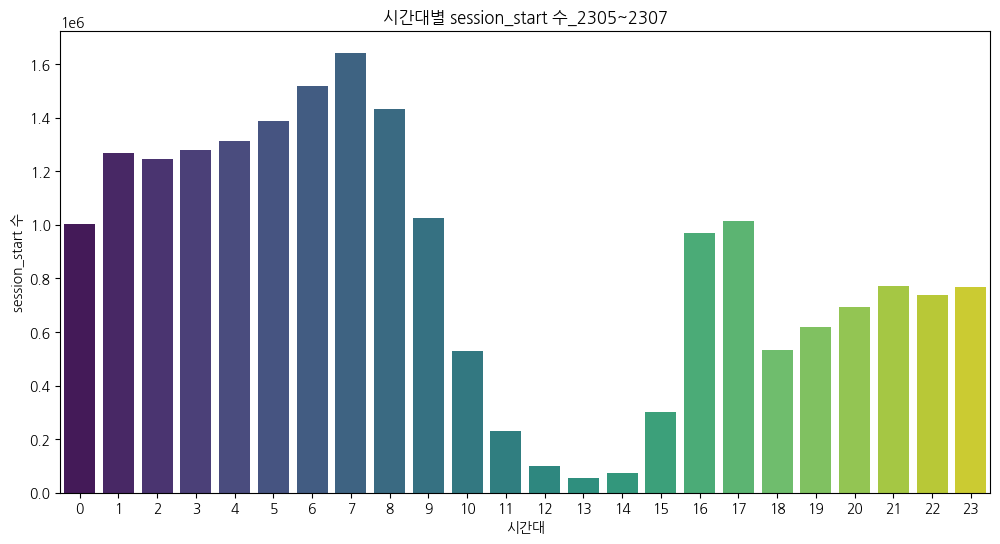

In [ ]:
# 시간대별로 session_start 이벤트 개수 집계
session_start_hour_counts = session_start_df['event_hour'].value_counts().sort_index().reset_index()
display(session_start_hour_counts)
display(session_start_hour_counts['count'].describe())

# 시간대별로 session_start 이벤트 개수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='viridis')
plt.title('시간대별 session_start 수_2305~2307')
plt.xlabel('시간대')   
plt.ylabel('session_start 수')   
plt.show()   

# 지표 도출_세션 지속 시간

## 세션 관련 EDA (session_start, session_end 탐색)

In [3]:
# 파일 불러오기(merged_df_final)
# 경로 설정
file_path = "gs://part4_project/events_ver2/merged_df_final.parquet"
key_path = "../config/codeit_project_vm_key.json"

# GCS에서 parquet 불러오기
merged_df = pd.read_parquet(file_path, storage_options={"token": key_path})

# 확인
print(merged_df.shape)
print(merged_df.info())

(55770129, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB
None


In [5]:
merged_df.head()

,event_datetime,device_id,event_key
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button


### 개수 기반 탐색

In [5]:
# device_id 별로 event_key별 개수 확인 
group_device_event_cnt_df = merged_df.groupby('device_id')['event_key'].value_counts().reset_index(name='count')
print(group_device_event_cnt_df.shape)
group_device_event_cnt_df.head()

(4415795, 3)


,device_id,event_key,count
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start,48
1,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end,38
2,0000065b-8c82-4982-b67e-ac67b1e4c38e,view_home_tap,20
3,0000065b-8c82-4982-b67e-ac67b1e4c38e,launch_app,12
4,0000065b-8c82-4982-b67e-ac67b1e4c38e,view_timeline_tap,5


In [6]:
group_device_event_cnt_df['device_id'].nunique() # device_id 952830개

952830

In [7]:
# event_key가 session_start와 session_end인 경우만 필터링
group_device_start_end_df = group_device_event_cnt_df[group_device_event_cnt_df['event_key'].isin(['$session_start', '$session_end'])]

# session_id별로 session_start와 session_end의 개수 확인 
pivot_device_start_end_df = group_device_start_end_df.pivot(index='device_id', columns='event_key', values='count').fillna(0).reset_index()

# 결과 확인
show_df_info(pivot_device_start_end_df,'pivot_device_start_end_df')                               


pivot_device_start_end_df 형태:


(951960, 3)


pivot_device_start_end_df 첫 5행:


event_key,device_id,$session_end,$session_start
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,38.0,48.0
1,000007c9-e103-4eb5-9777-a9084d4952df,7.0,62.0
2,00002245-458f-4cdd-8533-b448cd43dbd2,11.0,17.0
3,00004f65-e8bd-4a40-98af-202f2929dd6d,7.0,9.0
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,17.0,21.0



pivot_device_start_end_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951960 entries, 0 to 951959
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   device_id       951960 non-null  object 
 1   $session_end    951960 non-null  float64
 2   $session_start  951960 non-null  float64
dtypes: float64(2), object(1)
memory usage: 21.8+ MB

pivot_device_start_end_df 통계 요약:


event_key,$session_end,$session_start
count,951960.000000,951960.000000
mean,14.621831,21.548238
std,20.271605,25.073699
min,0.000000,0.000000
25%,1.000000,2.000000
50%,5.000000,12.000000
75%,22.000000,33.000000
max,306.000000,382.000000



pivot_device_start_end_df 통계 요약:


event_key,device_id
count,951960
unique,951960
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



pivot_device_start_end_df 결측치 확인:


event_key
device_id         0
$session_end      0
$session_start    0
dtype: int64

- 전체 고유한 device_id 952830개 중에, session_start/end가 없는 device_id 870개 (약 0.09%)
- session_start와 session_end 개수 max 값이 비정상적으로 큰 경우 존재

In [8]:
# session_start/end 별 0 개수 
print((pivot_device_start_end_df['$session_start'] == 0).sum())
print((pivot_device_start_end_df['$session_end'] == 0).sum())

1
193845


- session_start는 0인 경우 딱 1건
- session_end는 0인 경우 193845개...

In [9]:
# session_start는 0이고 session_end는 1이상인 경우
print(((pivot_device_start_end_df['$session_start'] == 0) & (pivot_device_start_end_df['$session_end'] >= 1)).sum())

# session_end가 0이고 session_start는 1이상인 경우 
print(((pivot_device_start_end_df['$session_end'] == 0) & (pivot_device_start_end_df['$session_start'] >= 1)).sum())

1
193845


- sesion_start가 찍히지 않고 session_end만 있는 경우 1개 
- session_end가 찍히지 않고 session_start만 있는 경우 193845개 (약 20.4%)

In [10]:
# session_start와 session_end 개수가 동일한 경우 추출 
pivot_device_start_end_df[pivot_device_start_end_df['$session_end'] == pivot_device_start_end_df['$session_start']] 

event_key,device_id,$session_end,$session_start
112,00088f45-6285-473c-bd06-08701429d051,7.0,7.0
149,000b88ba-1b4a-41e7-8838-95398e1c4761,3.0,3.0
193,000ef6d7-a147-4a2e-93f4-77f088fe867f,2.0,2.0
235,0011eec5-5718-4789-a848-17bdbf8ce29d,1.0,1.0
349,001a3296-b529-44f5-8e3a-d12abe9ac119,3.0,3.0
...,...,...,...
951575,ffe6bcab-69f7-4fca-97a9-ab01852b2d1b,1.0,1.0
951582,ffe72574-fc9f-4afe-abb2-5c2c23cdcb1e,8.0,8.0
951768,fff410f6-3eba-4008-a2bd-2f677e4a697a,2.0,2.0
951772,fff435a5-ed15-4220-83ef-8da89945b509,8.0,8.0


- 951960 개의 device_id중에서 12404개만 session_start와 session_end 개수 동일함 (약 1.30%)

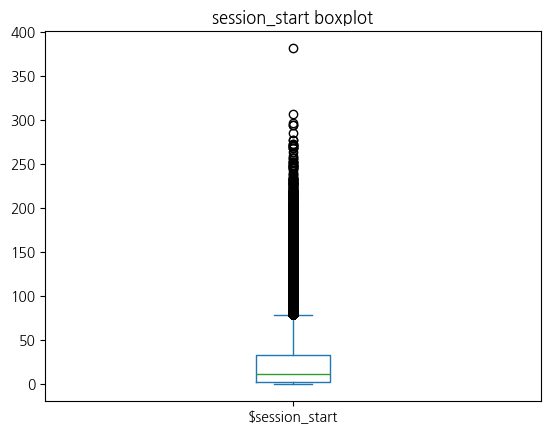

In [11]:
pivot_device_start_end_df['$session_start'].plot(kind = 'box')
plt.title('session_start boxplot')
plt.show()

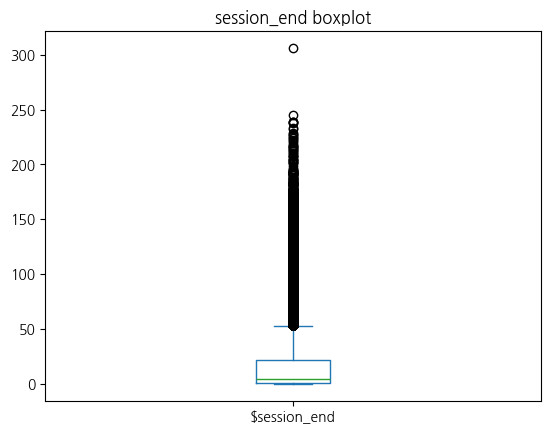

In [12]:
pivot_device_start_end_df['$session_end'].plot(kind = 'box')
plt.title('session_end boxplot')
plt.show()

- 이상치 중에서도 혼자 더 동떨어진 값이 존재 (session_start : 350이상, session_end : 270이상)

In [13]:
# 이상치 확인하기
q3 = pivot_device_start_end_df['$session_start'].quantile(0.75)
q1 = pivot_device_start_end_df['$session_start'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_device_start_end_df[(pivot_device_start_end_df['$session_start'] >= upper) | ((pivot_device_start_end_df['$session_start'] <= lower))]
    

event_key,device_id,$session_end,$session_start
5,00008546-4b7b-47cc-8b61-2ac9ac0745ae,92.0,107.0
21,0001c735-62f3-4888-b063-53ddc0a1a655,110.0,164.0
25,00020cb8-eaad-4b04-b18f-257b01aa60f0,68.0,102.0
80,000615c4-f671-45bb-bea4-7dc810606453,125.0,179.0
123,00097f8b-21e4-482e-80dc-7ee6105eee91,62.0,81.0
...,...,...,...
951910,fffc8f62-9f2b-4b26-8c65-88fd92ad2f41,84.0,95.0
951913,fffca979-e71c-4644-8b58-4823946f64ef,70.0,89.0
951915,fffce6bb-dac6-4f09-b029-730690c7da9e,63.0,87.0
951917,fffcee7c-0ba3-47a4-b382-21be88b88724,76.0,88.0


- 이상치로 분류된 device_id 약 3.60%

In [14]:
# 이상치 확인하기
q3 = pivot_device_start_end_df['$session_end'].quantile(0.75)
q1 = pivot_device_start_end_df['$session_end'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_device_start_end_df[(pivot_device_start_end_df['$session_end'] >= upper) | ((pivot_device_start_end_df['$session_end'] <= lower))]
    

event_key,device_id,$session_end,$session_start
5,00008546-4b7b-47cc-8b61-2ac9ac0745ae,92.0,107.0
14,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,61.0,77.0
21,0001c735-62f3-4888-b063-53ddc0a1a655,110.0,164.0
25,00020cb8-eaad-4b04-b18f-257b01aa60f0,68.0,102.0
41,000352dd-127b-44e6-8a8d-a118b1be5b33,55.0,56.0
...,...,...,...
951906,fffc025f-4da5-4a0f-9c0a-7c64b25cf0ac,54.0,86.0
951910,fffc8f62-9f2b-4b26-8c65-88fd92ad2f41,84.0,95.0
951913,fffca979-e71c-4644-8b58-4823946f64ef,70.0,89.0
951915,fffce6bb-dac6-4f09-b029-730690c7da9e,63.0,87.0


- 이상치로 분류된 device_id 약 5.98%

### 페어링 기반 탐색

In [4]:
# 필요한 컬럼만 추출
device_df = merged_df[merged_df['event_key'].isin(['$session_start', '$session_end'])]
# 시간 순 정렬
device_df = device_df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
show_df_info(device_df,'device_df')


device_df 형태:


(34432459, 3)


device_df 첫 5행:


,event_datetime,device_id,event_key
0,2023-05-16 18:02:01,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start
1,2023-05-16 18:02:48,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end
2,2023-05-16 18:02:50,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start
3,2023-05-16 21:41:52,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end
4,2023-05-16 23:43:19,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start



device_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34432459 entries, 0 to 34432458
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 788.1+ MB

device_df 통계 요약:


,event_datetime
count,34432459
mean,2023-05-21 04:38:13.430996736
min,2023-05-01 09:00:00
25%,2023-05-13 19:58:01
50%,2023-05-18 00:17:34
75%,2023-05-22 07:15:03
max,2023-07-12 08:59:59



device_df 통계 요약:


,device_id,event_key
count,34432459,34432459
unique,951960,2
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,$session_start
freq,688,20513061



device_df 결측치 확인:


event_datetime    0
device_id         0
event_key         0
dtype: int64

### 폐기된 방식 (start, end 각각의 순서 기반 매칭)

In [ ]:
# ## 다른 방법 시도

# def match_sessions_with_flags(df):
    
#     # # 시간 순 정렬
#     # df = df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
    
#     # start, end 분리
#     start_df = df[df['event_key'] == '$session_start'].copy()
#     end_df = df[df['event_key'] == '$session_end'].copy()

#     start_df = start_df.rename(columns={'event_datetime': 'start_time'})
#     end_df = end_df.rename(columns={'event_datetime': 'end_time'})

#     # 각 device_id 내에서 순서 부여
#     start_df['session_num'] = start_df.groupby('device_id').cumcount()
#     end_df['session_num'] = end_df.groupby('device_id').cumcount()

#     # outer join으로 start, end 모두 포함
#     merged = pd.merge(start_df[['device_id', 'session_num', 'start_time']],
#                       end_df[['device_id', 'session_num', 'end_time']],
#                       on=['device_id', 'session_num'],
#                       how='outer')

#     # 세션 길이 계산 (HH:MM:SS)
#     def format_duration(row):
#         if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
#             duration = (row['end_time'] - row['start_time']).total_seconds()
#             hours = int(duration // 3600)
#             minutes = int((duration % 3600) // 60)
#             seconds = int(duration % 60)
#             return f"{hours:02}:{minutes:02}:{seconds:02}"
#         else:
#             return None

#     merged['session_duration'] = merged.apply(format_duration, axis=1)

#     # 플래그 추가
#     def get_flag(row):
#         if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
#             return 'matched'
#         elif pd.notnull(row['start_time']) and pd.isna(row['end_time']):
#             return 'start_only'
#         elif pd.isna(row['start_time']) and pd.notnull(row['end_time']):
#             return 'end_only'
#         else:
#             return 'unknown'

#     merged['session_flag'] = merged.apply(get_flag, axis=1)

#     # 정렬
#     merged = merged.sort_values(by=['device_id', 'start_time', 'end_time']).reset_index(drop=True)

#     return merged


In [5]:
# print(matched_device_df['session_flag'].value_counts())
# print(matched_device_df['session_flag'].value_counts(normalize=True))  # 비율

### 최종 방식

In [ ]:
# import pandas as pd
# import numpy as np
# import multiprocessing as mp

# ▶︎ 1. 버퍼 방식 세션 매칭 함수 (device_id 기준 & 초 단위 duration)
def match_sessions_buffer(group_df):
    """
    device_id 기준으로 $session_start와 $session_end를 정확하게 매칭.
    가장 최근에 발생한 미매칭 start 이벤트와 end 이벤트를 1:1로 연결.
    session_duration은 초 단위.
    """
    # group_df = group_df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
    matched_sessions = []

    for device_id, group in group_df.groupby('device_id'):
        starts = []
        group = group.sort_values('event_datetime').reset_index(drop=True)

        # $session_start 저장
        for idx, row in group.iterrows():
            if row['event_key'] == '$session_start':
                starts.append({
                    'index': idx,
                    'start_time': row['event_datetime'],
                    'end_time': pd.NaT,
                    'matched': False
                })

        # $session_end와 가장 적절한 $session_start 매칭
        for idx, row in group.iterrows():
            if row['event_key'] == '$session_end':
                candidates = [s for s in starts if not s['matched'] and s['start_time'] <= row['event_datetime']]
                if candidates:
                    latest_start = max(candidates, key=lambda x: x['start_time'])
                    latest_start['end_time'] = row['event_datetime']
                    latest_start['matched'] = True
                else:
                    # 매칭 안 되는 end는 단독으로 기록
                    matched_sessions.append({
                        'device_id': device_id,
                        'start_time': pd.NaT,
                        'end_time': row['event_datetime'],
                        'session_duration_sec': np.nan
                    })

        # 매칭된 start 정보도 결과에 추가
        for s in starts:
            matched_sessions.append({
                'device_id': device_id,
                'start_time': s['start_time'],
                'end_time': s['end_time'],
                'session_duration_sec': (
                    (s['end_time'] - s['start_time']).total_seconds() if pd.notna(s['end_time']) else np.nan
                )
            })

    return pd.DataFrame(matched_sessions)



# ▶︎ 2. device_id 기준으로 데이터 균등 분할
def split_by_device_id(df, n_splits):
    """
    device_id 기준으로 groupby 후, group 단위로 균등 분할
    """
    grouped = list(df.groupby('device_id'))
    split_size = int(np.ceil(len(grouped) / n_splits))
    return [pd.concat([g for _, g in grouped[i:i+split_size]]) for i in range(0, len(grouped), split_size)]



# ▶︎ 3. 병렬 처리 실행 함수
def match_sessions_parallel(df, n_cores=None):
    """
    DataFrame을 균등하게 분할하여 병렬 처리 수행
    """
    if n_cores is None:
        n_cores = mp.cpu_count()

    df = df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
    df_splits = split_by_device_id(df, n_cores)

    with mp.Pool(n_cores) as pool:
        results = pool.map(match_sessions_buffer, df_splits)

    final_df = pd.concat(results, ignore_index=True)
    return final_df


In [7]:
# 병렬처리 방식 수정본
# import pandas as pd
# import numpy as np
# import multiprocessing as mp

# ▶︎ 1. 버퍼 방식 세션 매칭 함수 (device_id 기준 & 초 단위 duration)
def match_sessions_buffer(group_df):
    """
    단일 device_id에 대해 $session_start와 $session_end를 1:1로 매칭.
    """
    #group_df = group_df.sort_values('event_datetime').reset_index(drop=True)
    matched_sessions = []

    starts = []
    for idx, row in group_df.iterrows():
        if row['event_key'] == '$session_start':
            starts.append({
                'start_time': row['event_datetime'],
                'end_time': pd.NaT,
                'matched': False
            })
        elif row['event_key'] == '$session_end':
            # 가장 늦은 미매칭 start와 연결
            candidates = [s for s in starts if not s['matched'] and s['start_time'] <= row['event_datetime']]
            if candidates:
                latest_start = max(candidates, key=lambda x: x['start_time'])
                latest_start['end_time'] = row['event_datetime']
                latest_start['matched'] = True
            else:
                # 매칭 안 되는 end 이벤트
                matched_sessions.append({
                    'start_time': pd.NaT,
                    'end_time': row['event_datetime'],
                    'session_duration_sec': np.nan
                })

    # 모든 start 정보 추가
    for s in starts:
        matched_sessions.append({
            'start_time': s['start_time'],
            'end_time': s['end_time'],
            'session_duration_sec': (
                (s['end_time'] - s['start_time']).total_seconds() if pd.notna(s['end_time']) else np.nan
            )
        })

    # device_id 정보 추가
    for s in matched_sessions:
        s['device_id'] = group_df['device_id'].iloc[0]

    return pd.DataFrame(matched_sessions)


# ▶︎ 2. 병렬 처리 실행 함수 (group 단위로 바로)
def match_sessions_parallel_group(df, n_cores=None):
    """
    device_id 단위 groupby 후 병렬 처리.
    """
    if n_cores is None:
        n_cores = mp.cpu_count()

    # group 단위로 병렬 적용할 수 있도록 (device_id, group_df) 튜플로 변환
    grouped_data = [(device_id, group) for device_id, group in df.groupby('device_id')]

    # device_id별 그룹 처리 함수
    def process_group(args):
        _, group_df = args
        return match_sessions_buffer(group_df)

    with mp.Pool(n_cores) as pool:
        results = pool.map(process_group, grouped_data)

    return pd.concat(results, ignore_index=True)


In [8]:
matched_device_df = match_sessions_parallel(device_df)
print(matched_device_df.shape)

KeyboardInterrupt: 

In [18]:
show_df_info(matched_device_df,'matched_device_df')


matched_device_df 형태:


(20613559, 4)


matched_device_df 첫 5행:


,device_id,start_time,end_time,session_duration_sec
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 18:02:01,2023-05-16 18:02:48,47.0
1,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 18:02:50,2023-05-16 21:41:52,13142.0
2,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 23:43:19,2023-05-16 23:43:31,12.0
3,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-17 00:37:18,2023-05-17 00:41:21,243.0
4,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-17 07:18:12,2023-05-17 07:22:22,250.0



matched_device_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20613559 entries, 0 to 20613558
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   device_id             object        
 1   start_time            datetime64[ns]
 2   end_time              datetime64[ns]
 3   session_duration_sec  float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 629.1+ MB

matched_device_df 통계 요약:


,start_time,end_time,session_duration_sec
count,20513061,13919398,1.381890e+07
mean,2023-05-22 04:33:34.310831104,2023-05-19 17:22:56.817114368,2.004048e+05
min,2023-05-01 09:00:01,2023-05-01 09:00:00,0.000000e+00
25%,2023-05-14 07:18:13,2023-05-12 21:53:42,1.290000e+02
50%,2023-05-19 05:42:29,2023-05-16 16:03:26,2.148000e+03
75%,2023-05-24 18:30:57,2023-05-20 03:17:44,2.518400e+04
max,2023-07-12 08:59:59,2023-07-12 08:59:59,6.199678e+06
std,NaN,NaN,7.224619e+05



matched_device_df 통계 요약:


,device_id
count,20613559
unique,951960
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0
freq,382



matched_device_df 결측치 확인:


device_id                     0
start_time               100498
end_time                6694161
session_duration_sec    6794659
dtype: int64

In [19]:
6794659 / 20613559 * 100

32.962085780529215

In [9]:
# start_time과 end_time 모두 있는 경우 : matched
# start만 : start_only
# end만 : end_only

# 페어링 여부 컬럼 추가 
def check_matched(row):
    if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
        return 'matched'
    elif pd.notnull(row['start_time']) and pd.isna(row['end_time']):
        return 'start_only'
    elif pd.isna(row['start_time']) and pd.notnull(row['end_time']):
        return 'end_only'
    else:
        return 'unknown'

matched_device_df['session_flag'] = matched_device_df.apply(check_matched, axis=1) 
matched_device_df.head()

,device_id,start_time,end_time,session_duration_sec,session_flag
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 18:02:01,2023-05-16 18:02:48,47.0,matched
1,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 18:02:50,2023-05-16 21:41:52,13142.0,matched
2,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 23:43:19,2023-05-16 23:43:31,12.0,matched
3,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-17 00:37:18,2023-05-17 00:41:21,243.0,matched
4,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-17 07:18:12,2023-05-17 07:22:22,250.0,matched


In [10]:
# session_flag 별 확인
print('\nsession 매칭 여부 별 개수')
print(matched_device_df['session_flag'].value_counts())
print('\nsession 매칭 여부 별 개수 비율')
print(matched_device_df['session_flag'].value_counts(normalize=True))  # 비율


session 매칭 여부 별 개수
session_flag
matched       13818900
start_only     6694161
end_only        100498
Name: count, dtype: int64

session 매칭 여부 별 개수 비율
session_flag
matched       0.670379
start_only    0.324746
end_only      0.004875
Name: proportion, dtype: float64


#### start_time, end_time 결측치 보정(중앙값으로)

In [15]:
# start가 결측인 경우 end - 중앙값  / end가 결측인 경우 start + 중앙값 
# 중앙값을 timedelta로 변환
duration_median = matched_device_df[matched_device_df['session_flag'] == 'matched']['session_duration_sec'].median()
duration_td = pd.to_timedelta(duration_median, unit='s')

# 마스크 조건 설정
start_null = matched_device_df['start_time'].isnull() & matched_device_df['end_time'].notnull()
end_null = matched_device_df['end_time'].isnull() & matched_device_df['start_time'].notnull()

# 결측값 보정: start_time이 결측인 경우
matched_device_df.loc[start_null, 'start_time'] = matched_device_df.loc[start_null, 'end_time'] - duration_td
matched_device_df.loc[start_null, 'session_duration_sec'] = duration_median

# 결측값 보정: end_time이 결측인 경우
matched_device_df.loc[end_null, 'end_time'] = matched_device_df.loc[end_null, 'start_time'] + duration_td
matched_device_df.loc[end_null, 'session_duration_sec'] = duration_median


In [17]:
matched_device_df.isnull().sum()

device_id               0
start_time              0
end_time                0
session_duration_sec    0
session_flag            0
dtype: int64

In [19]:
show_df_info(matched_device_df, 'matched_device_df')


matched_device_df 형태:


(20613559, 5)


matched_device_df 첫 5행:


,device_id,start_time,end_time,session_duration_sec,session_flag
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 18:02:01,2023-05-16 18:02:48,47.0,matched
1,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 18:02:50,2023-05-16 21:41:52,13142.0,matched
2,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-16 23:43:19,2023-05-16 23:43:31,12.0,matched
3,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-17 00:37:18,2023-05-17 00:41:21,243.0,matched
4,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-05-17 07:18:12,2023-05-17 07:22:22,250.0,matched



matched_device_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20613559 entries, 0 to 20613558
Data columns (total 5 columns):
 #   Column                Dtype         
---  ------                -----         
 0   device_id             object        
 1   start_time            datetime64[ns]
 2   end_time              datetime64[ns]
 3   session_duration_sec  float64       
 4   session_flag          object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 786.3+ MB

matched_device_df 통계 요약:


,start_time,end_time,session_duration_sec
count,20613559,20613559,2.061356e+07
mean,2023-05-22 04:57:02.263409152,2023-05-23 18:27:57.462819328,1.350552e+05
min,2023-05-01 08:24:12,2023-05-01 09:00:00,0.000000e+00
25%,2023-05-14 07:07:02,2023-05-14 17:09:44,5.410000e+02
50%,2023-05-19 05:32:23,2023-05-19 09:50:49,2.148000e+03
75%,2023-05-24 18:35:53,2023-05-25 09:07:33,6.787000e+03
max,2023-07-12 08:59:59,2023-07-12 09:35:47,6.199678e+06
std,NaN,NaN,5.988244e+05



matched_device_df 통계 요약:


,device_id,session_flag
count,20613559,20613559
unique,951960,3
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,matched
freq,382,13818900



matched_device_df 결측치 확인:


device_id               0
start_time              0
end_time                0
session_duration_sec    0
session_flag            0
dtype: int64

In [ ]:
# flag == start_only였던 경우 확인
matched_device_df[matched_device_df['session_flag'] == 'start_only'].head(10)

,device_id,start_time,end_time,session_duration_sec,session_flag
38,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-06-27 11:21:34,2023-06-27 11:57:22,2148.0,start_only
39,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-06-29 00:43:57,2023-06-29 01:19:45,2148.0,start_only
40,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-01 23:10:22,2023-07-01 23:46:10,2148.0,start_only
41,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-02 01:29:59,2023-07-02 02:05:47,2148.0,start_only
42,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-02 02:17:24,2023-07-02 02:53:12,2148.0,start_only
43,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-04 16:43:28,2023-07-04 17:19:16,2148.0,start_only
44,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-05 06:59:20,2023-07-05 07:35:08,2148.0,start_only
45,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-06 09:53:07,2023-07-06 10:28:55,2148.0,start_only
46,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-08 08:51:09,2023-07-08 09:26:57,2148.0,start_only
47,0000065b-8c82-4982-b67e-ac67b1e4c38e,2023-07-09 11:22:59,2023-07-09 11:58:47,2148.0,start_only


In [ ]:
# flag == end_only였던 경우 확인
matched_device_df[matched_device_df['session_flag'] == 'end_only'].head(10)

,device_id,start_time,end_time,session_duration_sec,session_flag
527,0001b302-2e83-4ccd-b18b-5b3302e95d52,2023-06-28 00:35:44,2023-06-28 01:11:32,2148.0,end_only
956,00031f06-9dd4-4b4f-a551-f8b37ae9fd17,2023-07-12 00:43:49,2023-07-12 01:19:37,2148.0,end_only
1078,00035bcf-f6a0-40ce-b412-cdcb74cb52d7,2023-05-12 08:26:57,2023-05-12 09:02:45,2148.0,end_only
1215,0003ca39-e431-46a4-aa32-dee59450ca33,2023-06-25 07:33:21,2023-06-25 08:09:09,2148.0,end_only
1872,000615c4-f671-45bb-bea4-7dc810606453,2023-05-10 08:57:52,2023-05-10 09:33:40,2148.0,end_only
2227,0006bed8-512b-48f9-9b33-f79bb1e225a8,2023-05-19 04:46:11,2023-05-19 05:21:59,2148.0,end_only
2412,0007bc27-9d77-48e6-978c-b7dce49140a1,2023-05-06 06:38:47,2023-05-06 07:14:35,2148.0,end_only
2413,0007bc27-9d77-48e6-978c-b7dce49140a1,2023-05-07 02:08:23,2023-05-07 02:44:11,2148.0,end_only
2563,00088f45-6285-473c-bd06-08701429d051,2023-05-01 14:28:54,2023-05-01 15:04:42,2148.0,end_only
3165,000a1298-c564-4686-bd7c-9be41a5898c1,2023-05-17 23:07:48,2023-05-17 23:43:36,2148.0,end_only


## 세션 지속 시간 구하기

In [42]:
# device_id별 평균 지속시간 확인
device_duration_df = matched_device_df.groupby('device_id')['session_duration_sec'].mean().reset_index()
device_duration_df = device_duration_df.rename(columns = {'session_duration_sec': 'avg_duration_sec'})
device_duration_df = device_duration_df.sort_values(by = 'avg_duration_sec', ascending = False)
# 확인
show_df_info(device_duration_df,'device_duration_df')


device_duration_df 형태:


(951960, 2)


device_duration_df 첫 5행:


,device_id,avg_duration_sec
298993,5084b6aa-ef78-483a-84e4-6e7dd02c5b48,2720756.5
872846,eac44637-ba4b-4764-8aaf-7c7d91dbbe21,2707098.5
567449,98ee532e-c3a1-4617-bc58-eb2d0fac4410,2620037.5
235298,3f5285c2-44b3-4293-b98c-6efacee42c2c,2556823.5
276224,4a542922-020e-45a1-95f0-8cea37f630a8,2543589.5



device_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 951960 entries, 298993 to 822576
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         951960 non-null  object 
 1   avg_duration_sec  951960 non-null  float64
dtypes: float64(1), object(1)
memory usage: 21.8+ MB

device_duration_df 통계 요약:


,avg_duration_sec
count,9.519600e+05
mean,1.026483e+05
std,2.008883e+05
min,0.000000e+00
25%,2.148000e+03
50%,9.852321e+03
75%,1.037912e+05
max,2.720756e+06



device_duration_df 통계 요약:


,device_id
count,951960
unique,951960
top,5084b6aa-ef78-483a-84e4-6e7dd02c5b48
freq,1



device_duration_df 결측치 확인:


device_id           0
avg_duration_sec    0
dtype: int64

In [ ]:
# avg_duration_sec 이상치 확인 
q3 = device_duration_df['avg_duration_sec'].quantile(0.75)
q1 = device_duration_df['avg_duration_sec'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr  # 상한선
lower = q1 - 1.5 * iqr

# 이상치 제거한 데이터프레임
rm_outlier_df = device_duration_df[(device_duration_df['avg_duration_sec'] <= upper) & (device_duration_df['avg_duration_sec'] >= lower)]
show_df_info(rm_outlier_df,'rm_outlier_df')


rm_outlier_df 형태:


(823298, 2)


rm_outlier_df 첫 5행:


,device_id,avg_duration_sec
631034,a9d53544-6f9c-4e54-b760-d2650d6ceb2c,256249.780000
493909,850ba760-3d43-4ebc-85de-d76f2a994714,256248.217391
742537,c7c330e4-d186-4a35-97d6-6842b5f914ef,256245.785714
771147,cf75d2b3-45d1-4a5a-8722-962f85dc21cf,256241.478261
590638,9f2cd587-23be-4d9c-9592-4a6b7dab9fb8,256241.218182



rm_outlier_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 823298 entries, 631034 to 822576
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         823298 non-null  object 
 1   avg_duration_sec  823298 non-null  float64
dtypes: float64(1), object(1)
memory usage: 18.8+ MB

rm_outlier_df 통계 요약:


,avg_duration_sec
count,823298.000000
mean,35785.016526
std,58961.725472
min,0.000000
25%,2148.000000
50%,3683.490323
75%,41511.750000
max,256249.780000



rm_outlier_df 통계 요약:


,device_id
count,823298
unique,823298
top,a9d53544-6f9c-4e54-b760-d2650d6ceb2c
freq,1



rm_outlier_df 결측치 확인:


device_id           0
avg_duration_sec    0
dtype: int64

In [54]:
# timedelta → HH:mm:ss 문자열로 포맷 (총 시간 24시간 초과할 수 있으므로 직접 변환)
def format_hhmmss(td):
    total_seconds = int(td.total_seconds())
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"

rm_outlier_df.loc[:,'avg_duration_str'] = pd.to_timedelta(rm_outlier_df['avg_duration_sec'], unit='s').apply(format_hhmmss)


In [55]:
rm_outlier_df.head()

,device_id,avg_duration_sec,avg_duration_str
631034,a9d53544-6f9c-4e54-b760-d2650d6ceb2c,256249.780000,71:10:49
493909,850ba760-3d43-4ebc-85de-d76f2a994714,256248.217391,71:10:48
742537,c7c330e4-d186-4a35-97d6-6842b5f914ef,256245.785714,71:10:45
771147,cf75d2b3-45d1-4a5a-8722-962f85dc21cf,256241.478261,71:10:41
590638,9f2cd587-23be-4d9c-9592-4a6b7dab9fb8,256241.218182,71:10:41
